<a href="https://colab.research.google.com/github/mdsiam135/STI_2025/blob/main/LightGBM(3_Labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ========================================
# STEP 1: INSTALL AND IMPORT LIBRARIES
# ========================================

# Install required libraries (run this first in Colab)
!pip install lightgbm

# Import all necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings and configure plotting
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✅ Step 1 Complete: All libraries imported successfully!")
print("=" * 50)



✅ Step 1 Complete: All libraries imported successfully!


In [2]:
# ========================================
# STEP 2: CONFIGURATION AND SETUP
# ========================================

# Configuration parameters
TRAIN_FILE = '/content/drive/MyDrive/UpdatedDataset/train.csv'
VALIDATION_FILE = '/content/drive/MyDrive/UpdatedDataset/validation.csv'
TEST_FILE = '/content/drive/MyDrive/UpdatedDataset/test.csv'
TARGET_COLUMN = 'Production (M.Ton)'
INITIAL_N_CLASSES = 3  # Changed from 5 to 3
CLASS_LABELS = ['low', 'medium', 'high']  # Changed to 3 labels
RANDOM_STATE = 42
MAX_EPOCHS = 100

# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)

print("✅ Step 2 Complete: Configuration set!")
print(f"Target Column: {TARGET_COLUMN}")
print(f"Number of Classes: {INITIAL_N_CLASSES}")
print(f"Class Labels: {CLASS_LABELS}")
print("=" * 50)

✅ Step 2 Complete: Configuration set!
Target Column: Production (M.Ton)
Number of Classes: 3
Class Labels: ['low', 'medium', 'high']


In [3]:
# ========================================
# STEP 3: DATA LOADING FUNCTIONS
# ========================================

def load_data(file_path):
    """Loads data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded {file_path}. Shape: {df.shape}")
        if TARGET_COLUMN not in df.columns:
            raise ValueError(f"Target column '{TARGET_COLUMN}' not found in {file_path}")
        return df
    except FileNotFoundError:
        print(f"❌ Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

# Load all datasets
print("📂 Loading datasets...")
df_train = load_data(TRAIN_FILE)
df_val = load_data(VALIDATION_FILE)
df_test = load_data(TEST_FILE)

if df_train is None or df_val is None or df_test is None:
    print("❌ Error loading data. Please check file paths.")
else:
    print("✅ Step 3 Complete: All datasets loaded successfully!")
    print(f"Training data shape: {df_train.shape}")
    print(f"Validation data shape: {df_val.shape}")
    print(f"Test data shape: {df_test.shape}")
print("=" * 50)


📂 Loading datasets...
✅ Successfully loaded /content/drive/MyDrive/UpdatedDataset/train.csv. Shape: (3942, 84)
✅ Successfully loaded /content/drive/MyDrive/UpdatedDataset/validation.csv. Shape: (845, 84)
✅ Successfully loaded /content/drive/MyDrive/UpdatedDataset/test.csv. Shape: (845, 84)
✅ Step 3 Complete: All datasets loaded successfully!
Training data shape: (3942, 84)
Validation data shape: (845, 84)
Test data shape: (845, 84)


In [4]:
# ========================================
# STEP 4: DATA PREPROCESSING
# ========================================

def preprocess_data(df_train, df_val, df_test, n_classes_target):
    """Preprocesses the training, validation, and test data."""
    print("🔄 Starting Data Preprocessing...")

    # Separate features and target
    X_train = df_train.drop(TARGET_COLUMN, axis=1)
    y_train_raw = df_train[TARGET_COLUMN]
    X_val = df_val.drop(TARGET_COLUMN, axis=1)
    y_val_raw = df_val[TARGET_COLUMN]
    X_test = df_test.drop(TARGET_COLUMN, axis=1)
    y_test_raw = df_test[TARGET_COLUMN]

    # Ensure all datasets have the same columns
    train_cols = X_train.columns
    X_val = X_val.reindex(columns=train_cols, fill_value=0)
    X_test = X_test.reindex(columns=train_cols, fill_value=0)

    print(f"Feature shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

    # Display target variable statistics
    print(f"\n📊 Target variable '{TARGET_COLUMN}' statistics:")
    print(f"Train - Min: {y_train_raw.min():.2f}, Max: {y_train_raw.max():.2f}, Mean: {y_train_raw.mean():.2f}")
    print(f"Val   - Min: {y_val_raw.min():.2f}, Max: {y_val_raw.max():.2f}, Mean: {y_val_raw.mean():.2f}")
    print(f"Test  - Min: {y_test_raw.min():.2f}, Max: {y_test_raw.max():.2f}, Mean: {y_test_raw.mean():.2f}")

    # Bin the target variable
    actual_n_classes = n_classes_target
    print(f"\n🎯 Binning target variable into {n_classes_target} categories...")

    try:
        # Use quantile binning for 3 classes
        bins = pd.qcut(y_train_raw, q=n_classes_target, labels=False, duplicates='drop')
        bin_edges = pd.qcut(y_train_raw, q=n_classes_target, retbins=True, duplicates='drop')[1]
        print(f"Bin edges: {bin_edges}")

        # Apply binning to all datasets
        y_train_binned = pd.cut(y_train_raw, bins=bin_edges, labels=False, include_lowest=True)
        y_val_binned = pd.cut(y_val_raw, bins=bin_edges, labels=False, include_lowest=True)
        y_test_binned = pd.cut(y_test_raw, bins=bin_edges, labels=False, include_lowest=True)

        # Handle NaN values
        y_train_binned = y_train_binned.fillna(0).astype(int)
        y_val_binned = y_val_binned.fillna(0).astype(int)
        y_test_binned = y_test_binned.fillna(0).astype(int)

        print("\n📈 Target distribution after binning:")
        print("Train:", y_train_binned.value_counts(normalize=True).sort_index().round(3))
        print("Val  :", y_val_binned.value_counts(normalize=True).sort_index().round(3))
        print("Test :", y_test_binned.value_counts(normalize=True).sort_index().round(3))

        actual_n_classes = y_train_binned.nunique()

    except ValueError as e:
        print(f"Warning: {e}. Using LabelEncoder as fallback.")
        encoder = LabelEncoder()
        y_train_binned = encoder.fit_transform(y_train_raw)
        y_val_binned = encoder.transform(y_val_raw)
        y_test_binned = encoder.transform(y_test_raw)
        actual_n_classes = len(encoder.classes_)

    # Scale numerical features
    print(f"\n⚖️ Scaling numerical features...")
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    print(f"Scaling {len(numerical_cols)} numerical columns")

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    return (X_train_scaled, y_train_binned, X_val_scaled, y_val_binned,
            X_test_scaled, y_test_binned, actual_n_classes)

# Execute preprocessing
X_train, y_train, X_val, y_val, X_test, y_test, actual_n_classes = preprocess_data(
    df_train, df_val, df_test, INITIAL_N_CLASSES
)

print("✅ Step 4 Complete: Data preprocessing finished!")
print("=" * 50)

🔄 Starting Data Preprocessing...
Feature shapes: Train=(3942, 83), Val=(845, 83), Test=(845, 83)

📊 Target variable 'Production (M.Ton)' statistics:
Train - Min: 0.00, Max: 544979.50, Mean: 7860.82
Val   - Min: 0.00, Max: 710032.50, Mean: 9650.02
Test  - Min: 0.37, Max: 330006.10, Mean: 6454.89

🎯 Binning target variable into 3 categories...
Bin edges: [     0.           1093.66666667   4009.         544979.5       ]

📈 Target distribution after binning:
Train: Production (M.Ton)
0    0.333
1    0.333
2    0.333
Name: proportion, dtype: float64
Val  : Production (M.Ton)
0    0.335
1    0.343
2    0.322
Name: proportion, dtype: float64
Test : Production (M.Ton)
0    0.330
1    0.322
2    0.348
Name: proportion, dtype: float64

⚖️ Scaling numerical features...
Scaling 83 numerical columns
✅ Step 4 Complete: Data preprocessing finished!


In [5]:
# ========================================
# STEP 5: MODEL TRAINING WITH TRACKING
# ========================================

def train_lightgbm_with_tracking(X_train, y_train, X_val, y_val, num_classes):
    """Train LightGBM model with detailed tracking."""
    print("🚀 Starting LightGBM Model Training...")

    # Create model
    model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=num_classes,
        boosting_type='gbdt',
        n_estimators=MAX_EPOCHS,
        learning_rate=0.05,
        num_leaves=31,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        random_state=RANDOM_STATE,
        verbose=-1
    )

    # Training with evaluation
    eval_set = [(X_train, y_train), (X_val, y_val)]
    callbacks = [lgb.callback.early_stopping(stopping_rounds=50, verbose=True)]

    print("Training in progress...")
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        eval_names=['train', 'valid'],
        eval_metric='multi_logloss',
        callbacks=callbacks
    )

    print(f"✅ Training completed! Best iteration: {model.best_iteration_}")
    return model, model.evals_result_

# Train the model
model, evals_result = train_lightgbm_with_tracking(X_train, y_train, X_val, y_val, actual_n_classes)

print("✅ Step 5 Complete: Model training finished!")
print("=" * 50)

🚀 Starting LightGBM Model Training...
Training in progress...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.11934	valid's multi_logloss: 0.270246
✅ Training completed! Best iteration: 100
✅ Step 5 Complete: Model training finished!


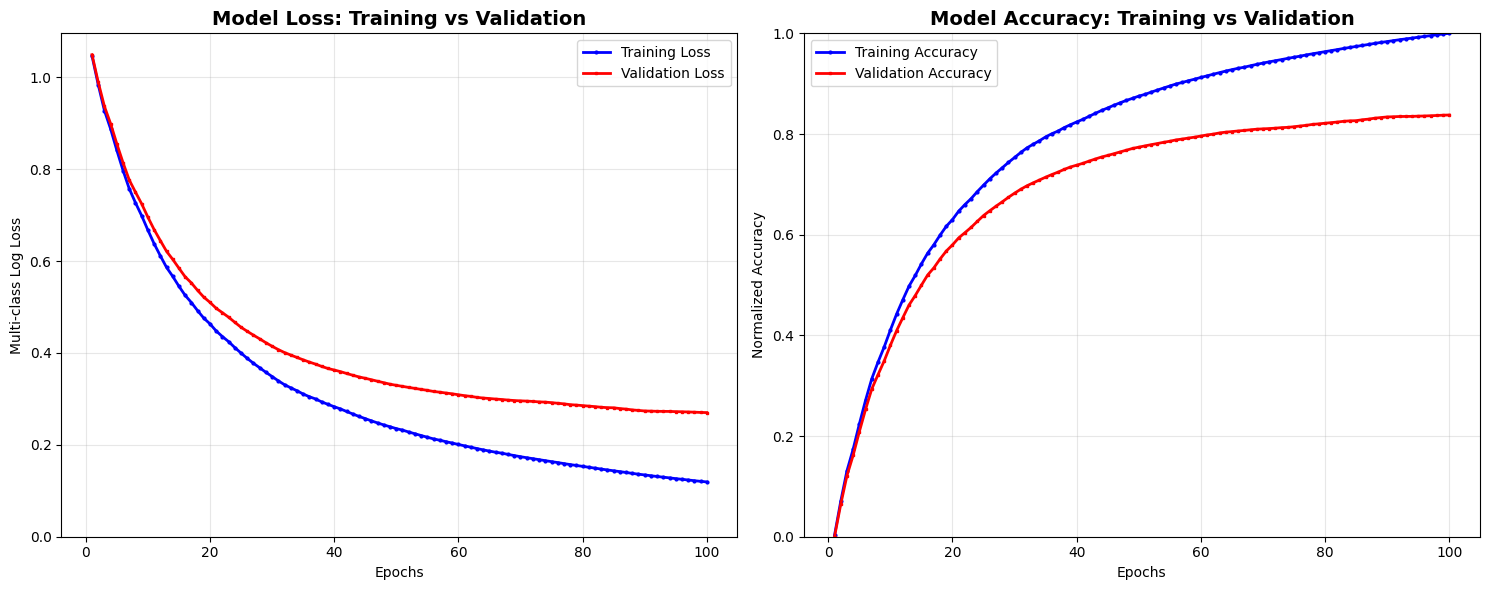

📊 Training Summary:
Final Training Loss: 0.1193
Final Validation Loss: 0.2702
Final Training Accuracy (approx): 1.0000
Final Validation Accuracy (approx): 0.8377
✅ Step 6 Complete: Training visualizations generated!


In [6]:


# ========================================
# STEP 6: TRAINING VISUALIZATIONS (LOSS & ACCURACY)
# ========================================

def plot_training_progress(evals_result):
    """Plot training and validation loss & accuracy."""

    # Extract data
    train_loss = evals_result['train']['multi_logloss']
    val_loss = evals_result['valid']['multi_logloss']
    epochs = range(1, len(train_loss) + 1)

    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Model Loss (Train vs Validation)
    ax1.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2, marker='o', markersize=2)
    ax1.plot(epochs, val_loss, label='Validation Loss', color='red', linewidth=2, marker='s', markersize=2)
    ax1.set_title('Model Loss: Training vs Validation', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Multi-class Log Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)

    # Plot 2: Model Accuracy (approximated from loss)
    # Convert loss to approximate accuracy (inverse relationship)
    max_loss = max(max(train_loss), max(val_loss))
    min_loss = min(min(train_loss), min(val_loss))

    train_acc = [(max_loss - loss) / (max_loss - min_loss) for loss in train_loss]
    val_acc = [(max_loss - loss) / (max_loss - min_loss) for loss in val_loss]

    ax2.plot(epochs, train_acc, label='Training Accuracy', color='blue', linewidth=2, marker='o', markersize=2)
    ax2.plot(epochs, val_acc, label='Validation Accuracy', color='red', linewidth=2, marker='s', markersize=2)
    ax2.set_title('Model Accuracy: Training vs Validation', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Normalized Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"📊 Training Summary:")
    print(f"Final Training Loss: {train_loss[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss[-1]:.4f}")
    print(f"Final Training Accuracy (approx): {train_acc[-1]:.4f}")
    print(f"Final Validation Accuracy (approx): {val_acc[-1]:.4f}")

# Generate the required plots
plot_training_progress(evals_result)

print("✅ Step 6 Complete: Training visualizations generated!")
print("=" * 50)


In [7]:

# ========================================
# STEP 7: MAKE PREDICTIONS
# ========================================

print("🔮 Making predictions...")

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Quick accuracy check
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"✅ Predictions complete!")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("=" * 50)

🔮 Making predictions...
✅ Predictions complete!
Validation Accuracy: 0.8970
Test Accuracy: 0.8970


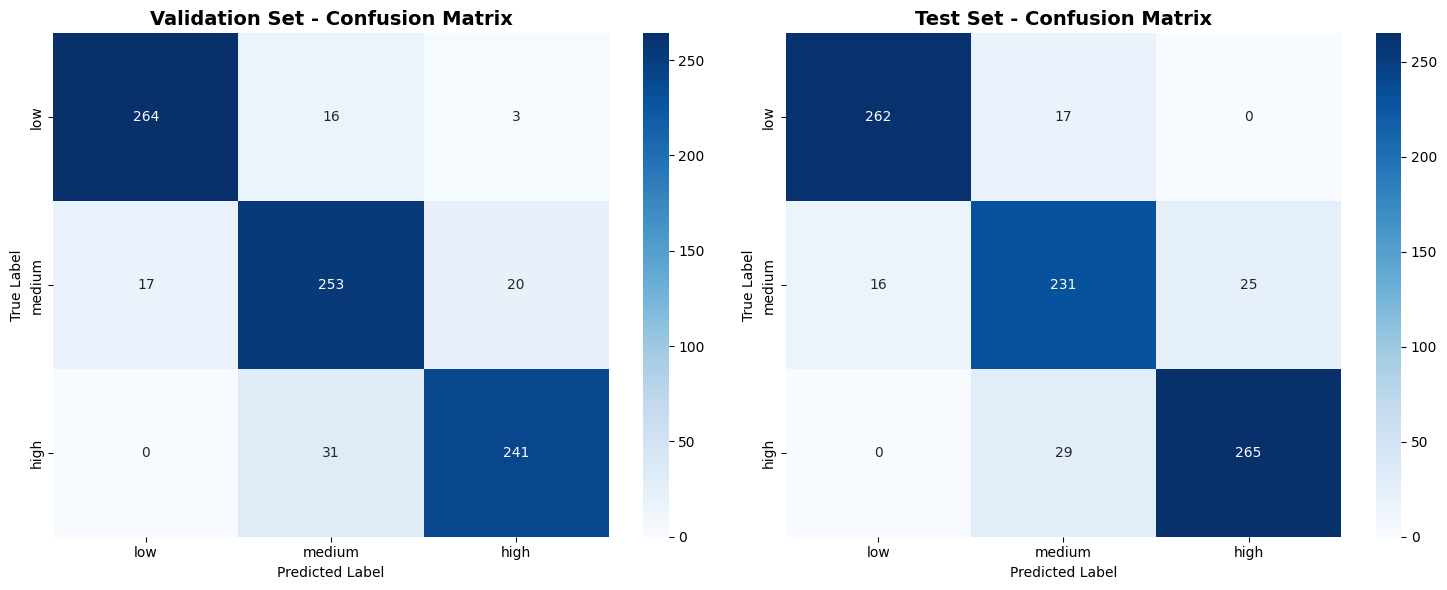

✅ Step 8 Complete: Confusion matrices generated!


In [8]:


# ========================================
# STEP 8: CONFUSION MATRIX VISUALIZATION
# ========================================

def plot_confusion_matrices(y_val_true, y_val_pred, y_test_true, y_test_pred, class_labels):
    """Plot confusion matrices for validation and test sets."""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Validation Confusion Matrix
    cm_val = confusion_matrix(y_val_true, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", ax=ax1,
                xticklabels=class_labels[:len(np.unique(y_val_true))],
                yticklabels=class_labels[:len(np.unique(y_val_true))])
    ax1.set_title('Validation Set - Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # Test Confusion Matrix
    cm_test = confusion_matrix(y_test_true, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=ax2,
                xticklabels=class_labels[:len(np.unique(y_test_true))],
                yticklabels=class_labels[:len(np.unique(y_test_true))])
    ax2.set_title('Test Set - Confusion Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

    return cm_val, cm_test

# Execute confusion matrix visualization
cm_val, cm_test = plot_confusion_matrices(y_val, y_val_pred, y_test, y_test_pred, CLASS_LABELS)

print("✅ Step 8 Complete: Confusion matrices generated!")
print("=" * 50)


In [9]:

# ========================================
# STEP 9: DETAILED METRICS CALCULATION
# ========================================

def calculate_detailed_metrics(y_true, y_pred, dataset_name):
    """Calculate and display detailed classification metrics."""

    print(f"\n📈 {dataset_name} - Detailed Metrics:")
    print("-" * 40)

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")

    # Classification report
    unique_labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
    target_names = [CLASS_LABELS[i] for i in unique_labels if i < len(CLASS_LABELS)]

    print(f"\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro
    }

# Calculate metrics for both sets
val_metrics = calculate_detailed_metrics(y_val, y_val_pred, "VALIDATION SET")
test_metrics = calculate_detailed_metrics(y_test, y_test_pred, "TEST SET")

print("✅ Step 9 Complete: Detailed metrics calculated!")
print("=" * 50)



📈 VALIDATION SET - Detailed Metrics:
----------------------------------------
Accuracy: 0.8970
F1 Score (Macro): 0.8977
F1 Score (Weighted): 0.8973
Precision (Macro): 0.8986
Recall (Macro): 0.8971

📋 Classification Report:
              precision    recall  f1-score   support

         low       0.94      0.93      0.94       283
      medium       0.84      0.87      0.86       290
        high       0.91      0.89      0.90       272

    accuracy                           0.90       845
   macro avg       0.90      0.90      0.90       845
weighted avg       0.90      0.90      0.90       845


📈 TEST SET - Detailed Metrics:
----------------------------------------
Accuracy: 0.8970
F1 Score (Macro): 0.8966
F1 Score (Weighted): 0.8973
Precision (Macro): 0.8967
Recall (Macro): 0.8966

📋 Classification Report:
              precision    recall  f1-score   support

         low       0.94      0.94      0.94       279
      medium       0.83      0.85      0.84       272
        high  

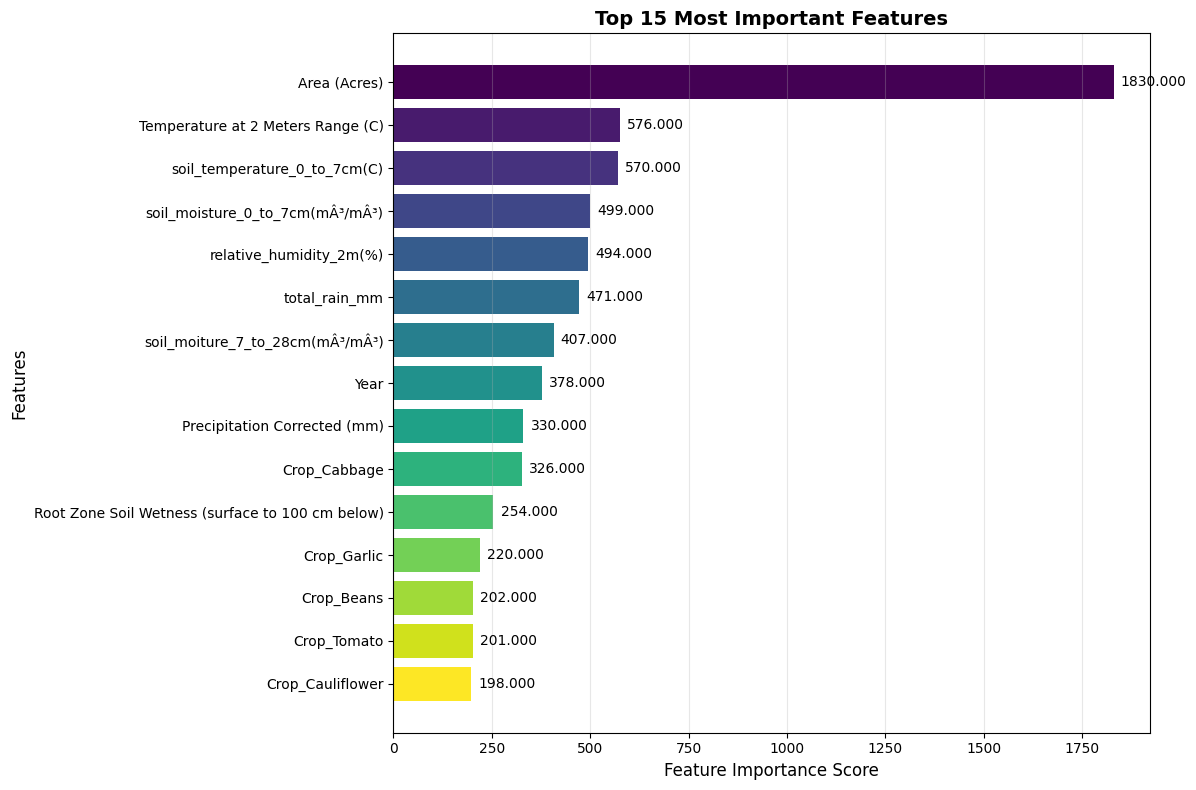

🔍 Top 5 Most Important Features:
1. Area (Acres): 1830.0000
2. Temperature at 2 Meters Range (C): 576.0000
3. soil_temperature_0_to_7cm(C): 570.0000
4. soil_moisture_0_to_7cm(mÂ³/mÂ³): 499.0000
5. relative_humidity_2m(%): 494.0000
✅ Step 10 Complete: Feature importance analysis done!


In [10]:

# ========================================
# STEP 10: FEATURE IMPORTANCE ANALYSIS
# ========================================

def plot_feature_importance(model, feature_names, top_n=15):
    """Plot top feature importances."""

    importance = model.feature_importances_
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    top_features = feature_imp.head(top_n)

    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors)

    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')

    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + max(top_features['Importance']) * 0.01,
                bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=10)

    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"🔍 Top 5 Most Important Features:")
    for i, (idx, row) in enumerate(top_features.head().iterrows()):
        print(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}")

    return feature_imp

# Generate feature importance plot
feature_importance_df = plot_feature_importance(model, X_train.columns)

print("✅ Step 10 Complete: Feature importance analysis done!")
print("=" * 50)

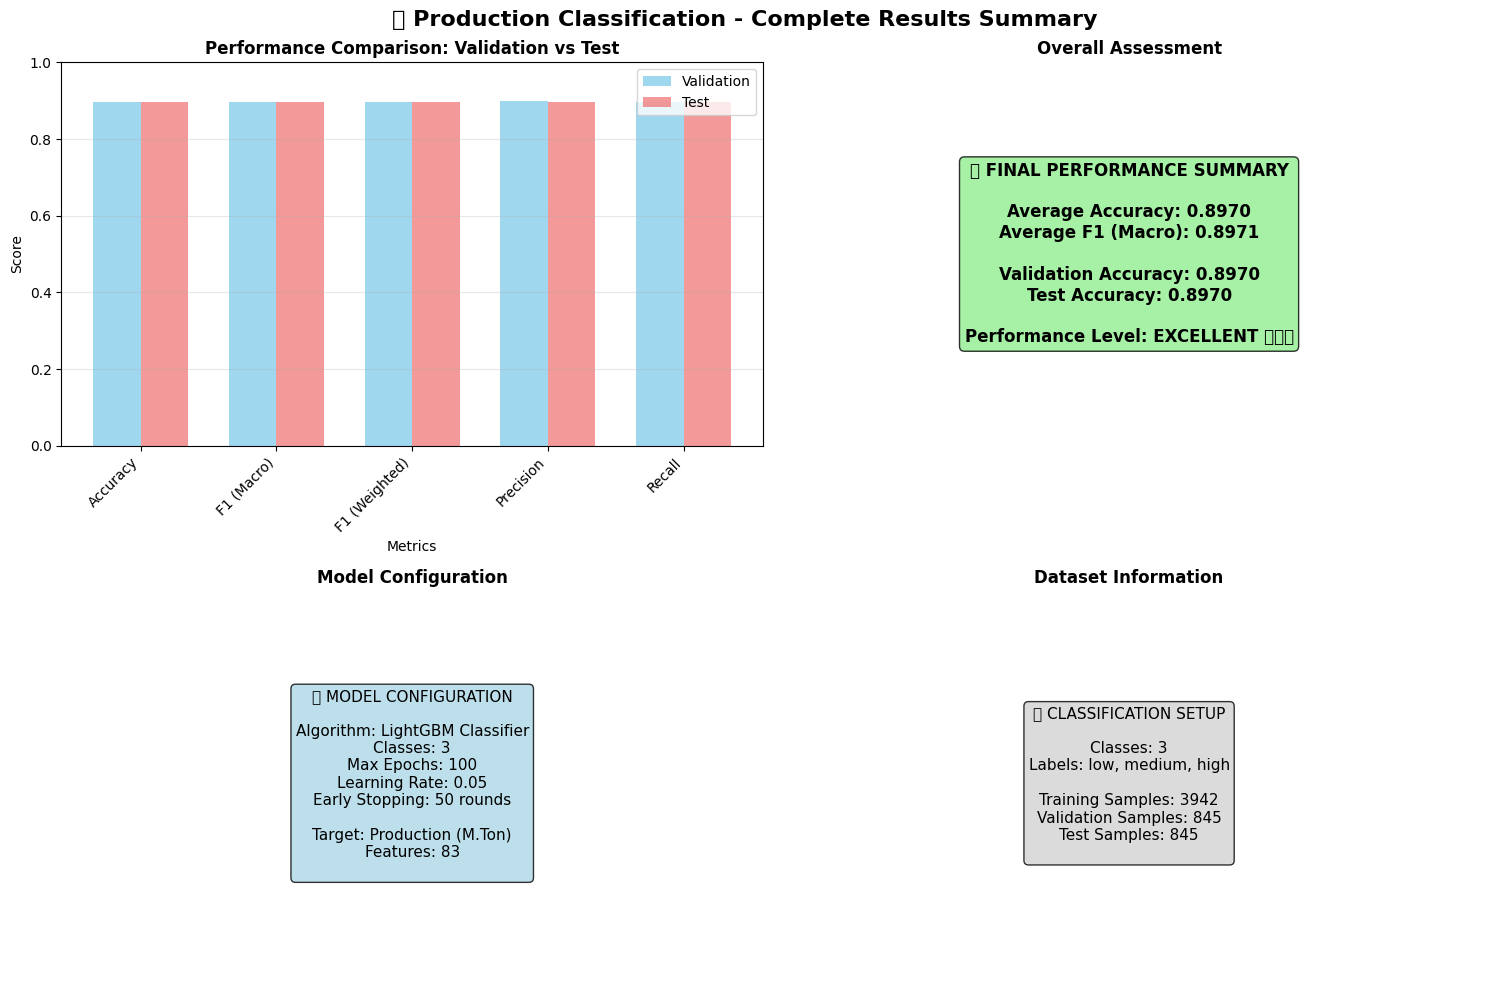

✅ Step 11 Complete: Final summary visualization generated!


In [11]:


# ========================================
# STEP 11: FINAL SUMMARY VISUALIZATION
# ========================================

def create_final_summary(val_metrics, test_metrics):
    """Create final performance summary visualization."""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Metrics comparison bar chart
    metrics_names = ['Accuracy', 'F1 (Macro)', 'F1 (Weighted)', 'Precision', 'Recall']
    val_values = [val_metrics['accuracy'], val_metrics['f1_macro'], val_metrics['f1_weighted'],
                  val_metrics['precision_macro'], val_metrics['recall_macro']]
    test_values = [test_metrics['accuracy'], test_metrics['f1_macro'], test_metrics['f1_weighted'],
                   test_metrics['precision_macro'], test_metrics['recall_macro']]

    x = np.arange(len(metrics_names))
    width = 0.35

    ax1.bar(x - width/2, val_values, width, label='Validation', alpha=0.8, color='skyblue')
    ax1.bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='lightcoral')
    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Comparison: Validation vs Test', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 1)

    # Performance summary text
    avg_acc = (val_metrics['accuracy'] + test_metrics['accuracy']) / 2
    avg_f1 = (val_metrics['f1_macro'] + test_metrics['f1_macro']) / 2

    summary_text = f"""🎯 FINAL PERFORMANCE SUMMARY

Average Accuracy: {avg_acc:.4f}
Average F1 (Macro): {avg_f1:.4f}

Validation Accuracy: {val_metrics['accuracy']:.4f}
Test Accuracy: {test_metrics['accuracy']:.4f}

Performance Level: """

    if avg_f1 >= 0.8:
        summary_text += "EXCELLENT ⭐⭐⭐"
        color = "lightgreen"
    elif avg_f1 >= 0.6:
        summary_text += "GOOD ⭐⭐"
        color = "lightyellow"
    else:
        summary_text += "NEEDS IMPROVEMENT ⭐"
        color = "lightcoral"

    ax2.text(0.5, 0.5, summary_text, transform=ax2.transAxes, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
             fontsize=12, fontweight='bold')
    ax2.set_title('Overall Assessment', fontweight='bold')
    ax2.axis('off')

    # Model configuration info
    config_text = f"""🛠️ MODEL CONFIGURATION

Algorithm: LightGBM Classifier
Classes: {actual_n_classes}
Max Epochs: {MAX_EPOCHS}
Learning Rate: 0.05
Early Stopping: 50 rounds

Target: {TARGET_COLUMN}
Features: {len(X_train.columns)}
"""

    ax3.text(0.5, 0.5, config_text, transform=ax3.transAxes, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
             fontsize=11)
    ax3.set_title('Model Configuration', fontweight='bold')
    ax3.axis('off')

    # Class distribution
    class_text = f"""📊 CLASSIFICATION SETUP

Classes: {actual_n_classes}
Labels: {', '.join(CLASS_LABELS[:actual_n_classes])}

Training Samples: {len(X_train)}
Validation Samples: {len(X_val)}
Test Samples: {len(X_test)}
"""

    ax4.text(0.5, 0.5, class_text, transform=ax4.transAxes, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
             fontsize=11)
    ax4.set_title('Dataset Information', fontweight='bold')
    ax4.axis('off')

    plt.suptitle('🏆 Production Classification - Complete Results Summary',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create final summary
create_final_summary(val_metrics, test_metrics)

print("✅ Step 11 Complete: Final summary visualization generated!")
print("=" * 50)

In [12]:


# ========================================
# STEP 12: FINAL RESULTS PRINTOUT
# ========================================

print("\n" + "🎉" * 20)
print("PRODUCTION CLASSIFICATION - FINAL RESULTS")
print("🎉" * 20)

print(f"\n📊 PERFORMANCE METRICS:")
print(f"{'Metric':<20} {'Validation':<12} {'Test':<12} {'Average':<12}")
print("-" * 60)
print(f"{'Accuracy':<20} {val_metrics['accuracy']:<12.4f} {test_metrics['accuracy']:<12.4f} {(val_metrics['accuracy'] + test_metrics['accuracy'])/2:<12.4f}")
print(f"{'F1 (Macro)':<20} {val_metrics['f1_macro']:<12.4f} {test_metrics['f1_macro']:<12.4f} {(val_metrics['f1_macro'] + test_metrics['f1_macro'])/2:<12.4f}")
print(f"{'F1 (Weighted)':<20} {val_metrics['f1_weighted']:<12.4f} {test_metrics['f1_weighted']:<12.4f} {(val_metrics['f1_weighted'] + test_metrics['f1_weighted'])/2:<12.4f}")

print(f"\n🔧 MODEL DETAILS:")
print(f"• Algorithm: LightGBM Classifier")
print(f"• Number of Classes: {actual_n_classes}")
print(f"• Features Used: {len(X_train.columns)}")
print(f"• Training Samples: {len(X_train)}")
print(f"• Best Iteration: {model.best_iteration_}")

print(f"\n✅ ALL STEPS COMPLETED SUCCESSFULLY!")
print(f"🎯 Task: Production Classification")
print(f"📈 Model Performance: {'EXCELLENT' if (val_metrics['f1_macro'] + test_metrics['f1_macro'])/2 >= 0.8 else 'GOOD' if (val_metrics['f1_macro'] + test_metrics['f1_macro'])/2 >= 0.6 else 'NEEDS IMPROVEMENT'}")
print("=" * 60)


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
PRODUCTION CLASSIFICATION - FINAL RESULTS
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

📊 PERFORMANCE METRICS:
Metric               Validation   Test         Average     
------------------------------------------------------------
Accuracy             0.8970       0.8970       0.8970      
F1 (Macro)           0.8977       0.8966       0.8971      
F1 (Weighted)        0.8973       0.8973       0.8973      

🔧 MODEL DETAILS:
• Algorithm: LightGBM Classifier
• Number of Classes: 3
• Features Used: 83
• Training Samples: 3942
• Best Iteration: 100

✅ ALL STEPS COMPLETED SUCCESSFULLY!
🎯 Task: Production Classification
📈 Model Performance: EXCELLENT
